# Part 1, Data Discovery

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection  import cross_val_score

from scipy import stats
import seaborn as sns
from copy import deepcopy

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

In this part, we do a short data exploration to see what dataset we have and whether we can find any patterns in it.

Also, we'll discover that some data transformations are needed to prepare the dataset for our modelling. A very important section of data discovery phase is to make sure that train and test sets are taken from the same distribution. This is a required step if we want to use cross-validation on the training set and be sure that our models' generalizations will work the same way on test.


Unfortunately, this knowledge will be mostly useless for this Capstone since we're not going to use unlabeled test set. Though, I still include this part of research in this Capstone due to its importance.

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Aggregated and basic statistics

First, let's get accustomed with dataset and get some basic data about it:

In [5]:
train.shape

(188318, 132)

188K training examples, 132 columns — this does not look like a massive dataset. We can definitely train most of our models on a local machine.

In [9]:
print('First 20 columns:', list(train.columns[:20]))

print('\nLast 20 columns:', list(train.columns[-20:]))

First 20 columns: ['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19']

Last 20 columns: ['cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss']


We see that there are probably 116 categorical columns (as their names suggest) and 14 continuous (numerical) columns.

Also, there's `id` and `loss` columns. This sums up to 132 columns total.

Next, let's see a quick statistic summary of our continuous features:

In [10]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


As we see, all continuous features have been scaled to `[0,1]` interval and have means around 0.5. This is the result of anonymization and some sort of data preprocessing that was done by Allstate.

On the other hand, `loss` values are not scaled (though they might have been preprocessed as well).

### Testing on missing values

We should always dedicate a part of our research on dealing with missing values. Pandas provides an easy way to detect them:

In [11]:
pd.isnull(train).values.any()

False

There are **no missing values at all.** This is a great relief and this definitely allows us to focus on algorithms and not on data cleansing.

## Continuous vs caterogical features

Another way to see the division to categorical and continuous features is to run `pd.DataFrame.info` method:

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 106.3+ MB


In here, `float64(15), int64(1)` are our continuous features (the one with `int64` is probably `id`) while `object(116)` are categorical features. We may confirm this:

In [15]:
cat_features = list(train.select_dtypes(include=['object']).columns)
print("Categorical: {} features".format(len(cat_features)))

Categorical: 116 features


In [16]:
cont_features = [cont for cont in list(train.select_dtypes(
                 include=['float64', 'int64']).columns) if cont not in ['loss', 'id']]
print("Continuous: {} features".format(len(cont_features)))

Continuous: 14 features


In [17]:
id_col = list(train.select_dtypes(include=['int64']).columns)
print("A column of int64: {}".format(id_col))

A column of int64: ['id']


## Unique values in categorical features

Let's plot a histogram visualizing the count of features with a specific amount of values.

In [52]:
cat_uniques = []
for cat in cat_features:
    cat_uniques.append(len(train[cat].unique()))
    
uniq_values_in_categories = pd.DataFrame.from_dict({'cat_name':cat_features, 'unique_values':cat_uniques})

In [53]:
uniq_values_in_categories.head()

,cat_name,unique_values
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2


In [54]:
print(uniq_values_in_categories.unique_values)

0        2
1        2
2        2
3        2
4        2
      ... 
111     51
112     61
113     19
114     23
115    326
Name: unique_values, Length: 116, dtype: int64


Text(7, 71, 'Binary features')

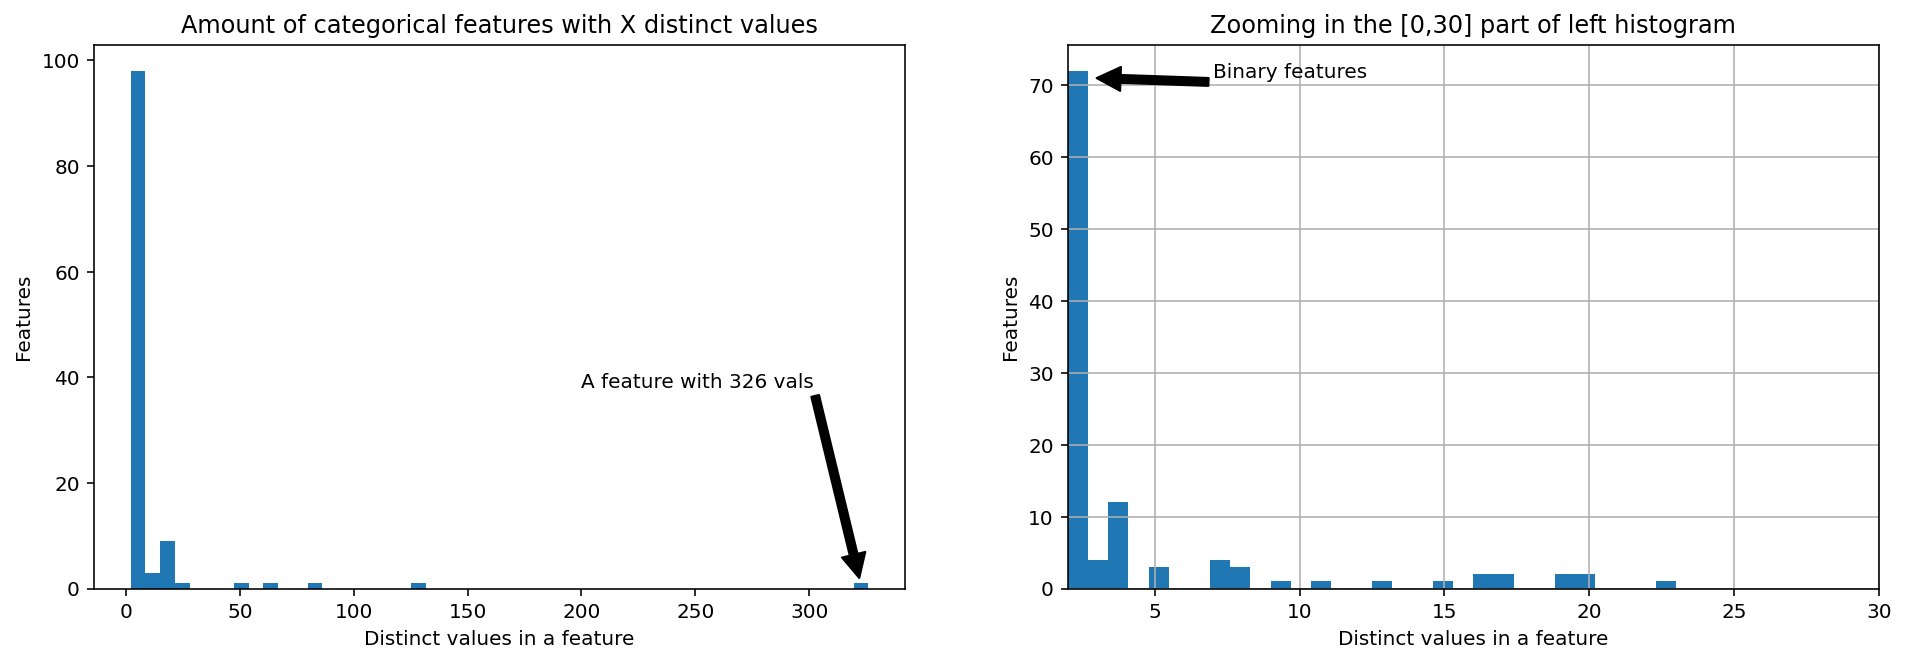

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(uniq_values_in_categories.unique_values, bins=50)
ax1.set_title('Amount of categorical features with X distinct values')
ax1.set_xlabel('Distinct values in a feature')
ax1.set_ylabel('Features')
ax1.annotate('A feature with 326 vals', xy=(322, 2), xytext=(200, 38), arrowprops=dict(facecolor='black'))

ax2.set_xlim(2,30)
ax2.set_title('Zooming in the [0,30] part of left histogram')
ax2.set_xlabel('Distinct values in a feature')
ax2.set_ylabel('Features')
ax2.grid(True)
ax2.hist(uniq_values_in_categories[uniq_values_in_categories.unique_values <= 30].unique_values, bins=30)
ax2.annotate('Binary features', xy=(3, 71), xytext=(7, 71), arrowprops=dict(facecolor='black'))

In [57]:
# Another option is to use Series.value_counts() method, but its
# output is not that nice

uniq_values = uniq_values_in_categories.groupby('unique_values').count()
uniq_values = uniq_values.rename(columns={'cat_name': 'categories'})
uniq_values.sort_values(by='categories', inplace=True, ascending=False)
uniq_values.reset_index(inplace=True)
print(uniq_values)

    unique_values  categories
0               2          72
1               4          12
2               3           4
3               7           4
4               5           3
5               8           3
6              20           2
7              19           2
8              17           2
9              16           2
10             15           1
11             13           1
12             11           1
13              9           1
14             23           1
15             51           1
16             61           1
17             84           1
18            131           1
19            326           1


As we see, most of the categorical features (72 / 116) are binary, the vast majority of the features (88 / 116) have up to four values, there's one feature with 326 values (a day number?).

## Target Feature

First, we just plot the target:

No handles with labels found to put in legend.


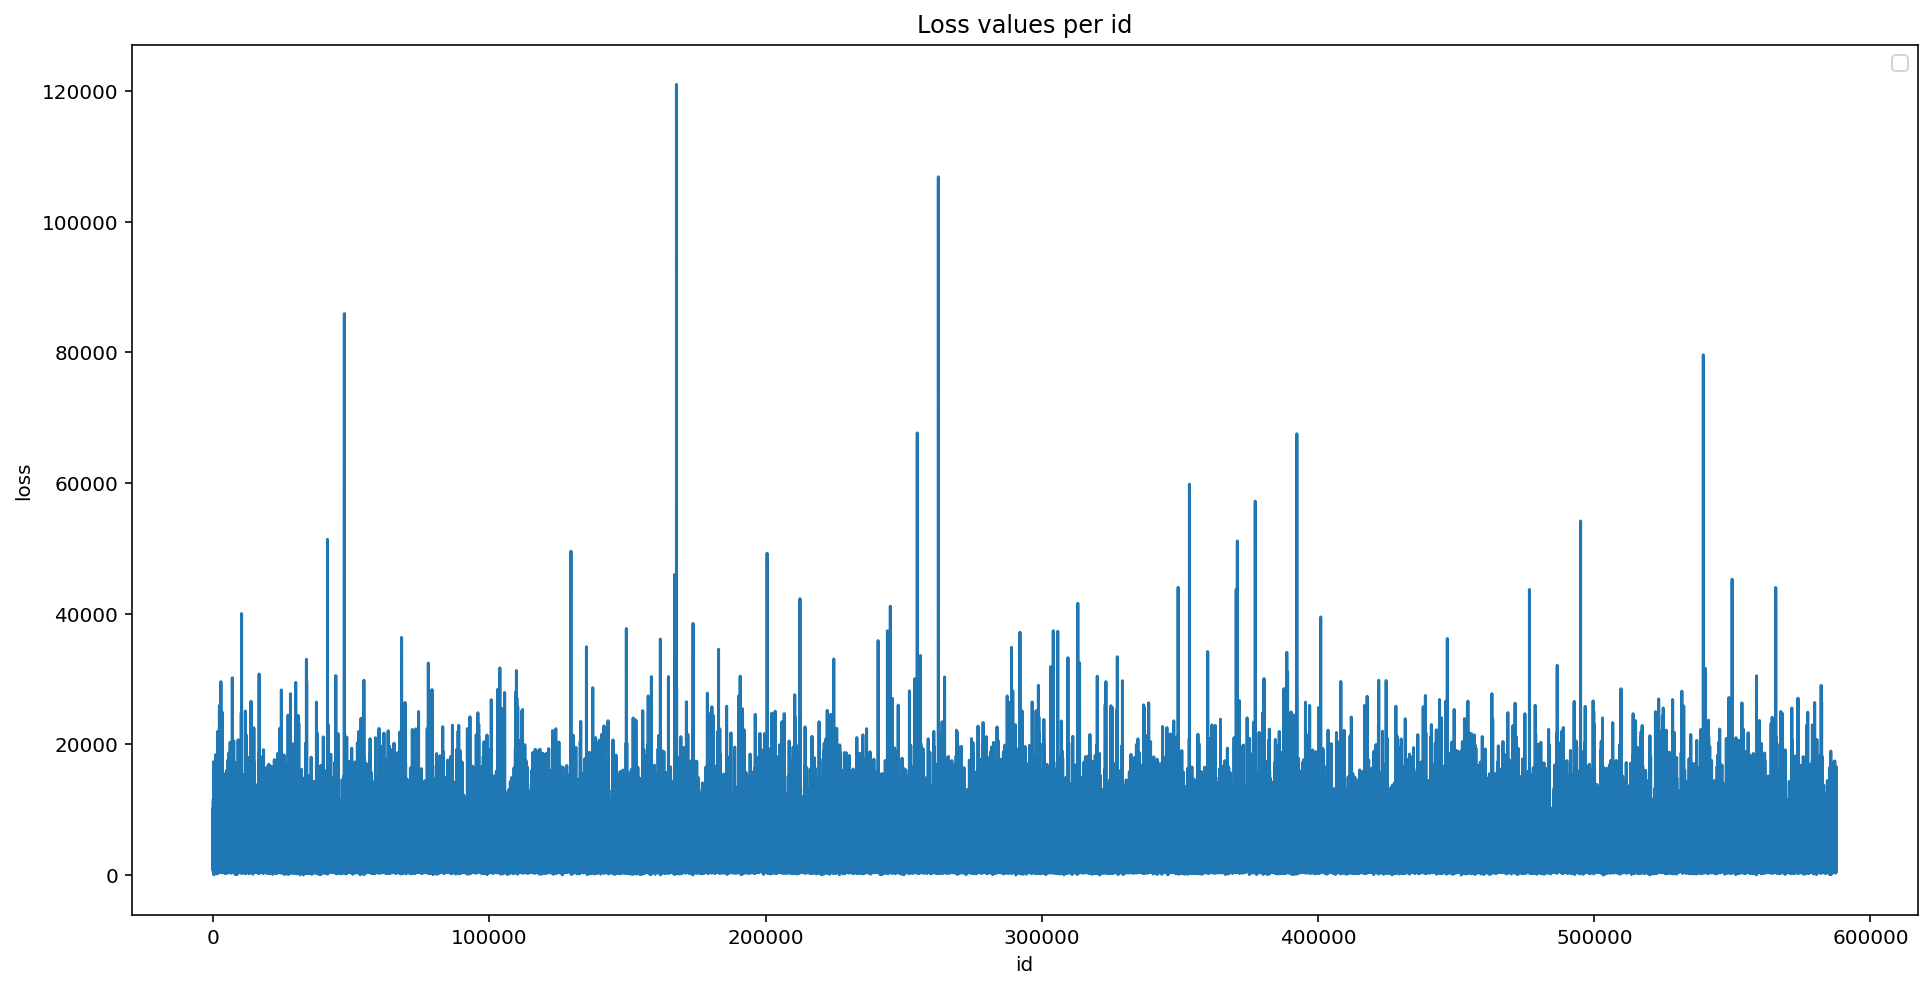

In [58]:
plt.figure(figsize=(16,8))
plt.plot(train['id'], train['loss'])
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

There are several distinctive peaks in the loss values representing severe accidents. Such data distribution makes this feature very skewed and can result in suboptimal performance of the regressor.

Basically, [skewness](https://en.wikipedia.org/wiki/Skewness) measures the asymmetry of the probability distribution of a real-valued random variable about its mean. Let's calculate the skewness of `loss`:

In [59]:
stats.mstats.skew(train['loss']).data

array(3.79492815)

Yes, the data is skewed. We can measure the skewness with `stats.mstats.skew`:

When we apply `np.log` to this vector, we get better results:

In [60]:
stats.mstats.skew(np.log(train['loss'])).data

array(0.0929738)

To make sure our analysis is correct, we can plot a histogram of the loss. We also log-transform the target and plot its updated histogram.

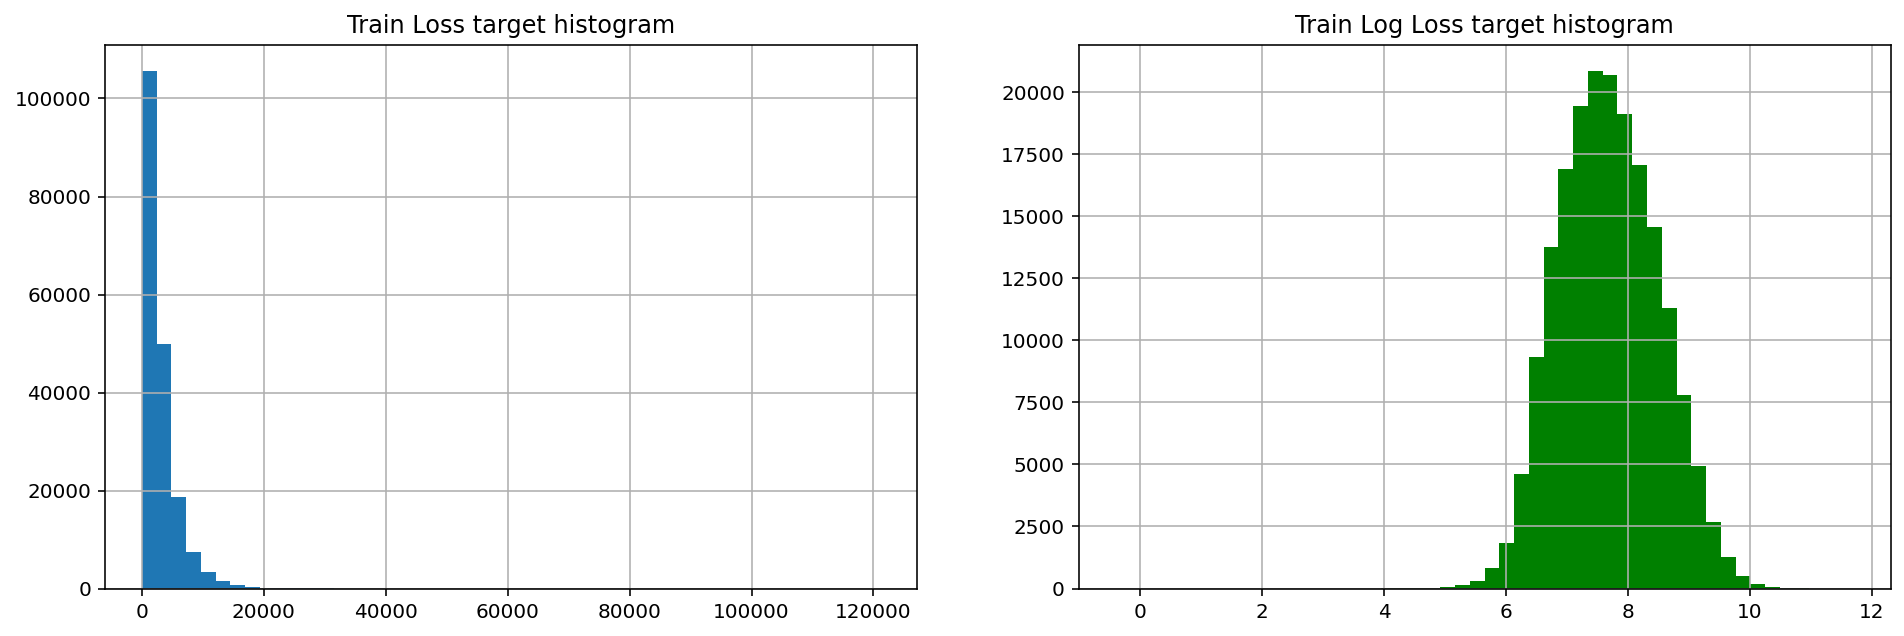

In [61]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'], bins=50)
ax1.set_title('Train Loss target histogram')
ax1.grid(True)
ax2.hist(np.log(train['loss']), bins=50, color='g')
ax2.set_title('Train Log Loss target histogram')
ax2.grid(True)
plt.show()

## Continuous features

One thing we can do is to plot histogram of the numerical features and analyze their distributions:

array([[<AxesSubplot:title={'center':'cont1'}>,
        <AxesSubplot:title={'center':'cont2'}>,
        <AxesSubplot:title={'center':'cont3'}>,
        <AxesSubplot:title={'center':'cont4'}>],
       [<AxesSubplot:title={'center':'cont5'}>,
        <AxesSubplot:title={'center':'cont6'}>,
        <AxesSubplot:title={'center':'cont7'}>,
        <AxesSubplot:title={'center':'cont8'}>],
       [<AxesSubplot:title={'center':'cont9'}>,
        <AxesSubplot:title={'center':'cont10'}>,
        <AxesSubplot:title={'center':'cont11'}>,
        <AxesSubplot:title={'center':'cont12'}>],
       [<AxesSubplot:title={'center':'cont13'}>,
        <AxesSubplot:title={'center':'cont14'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

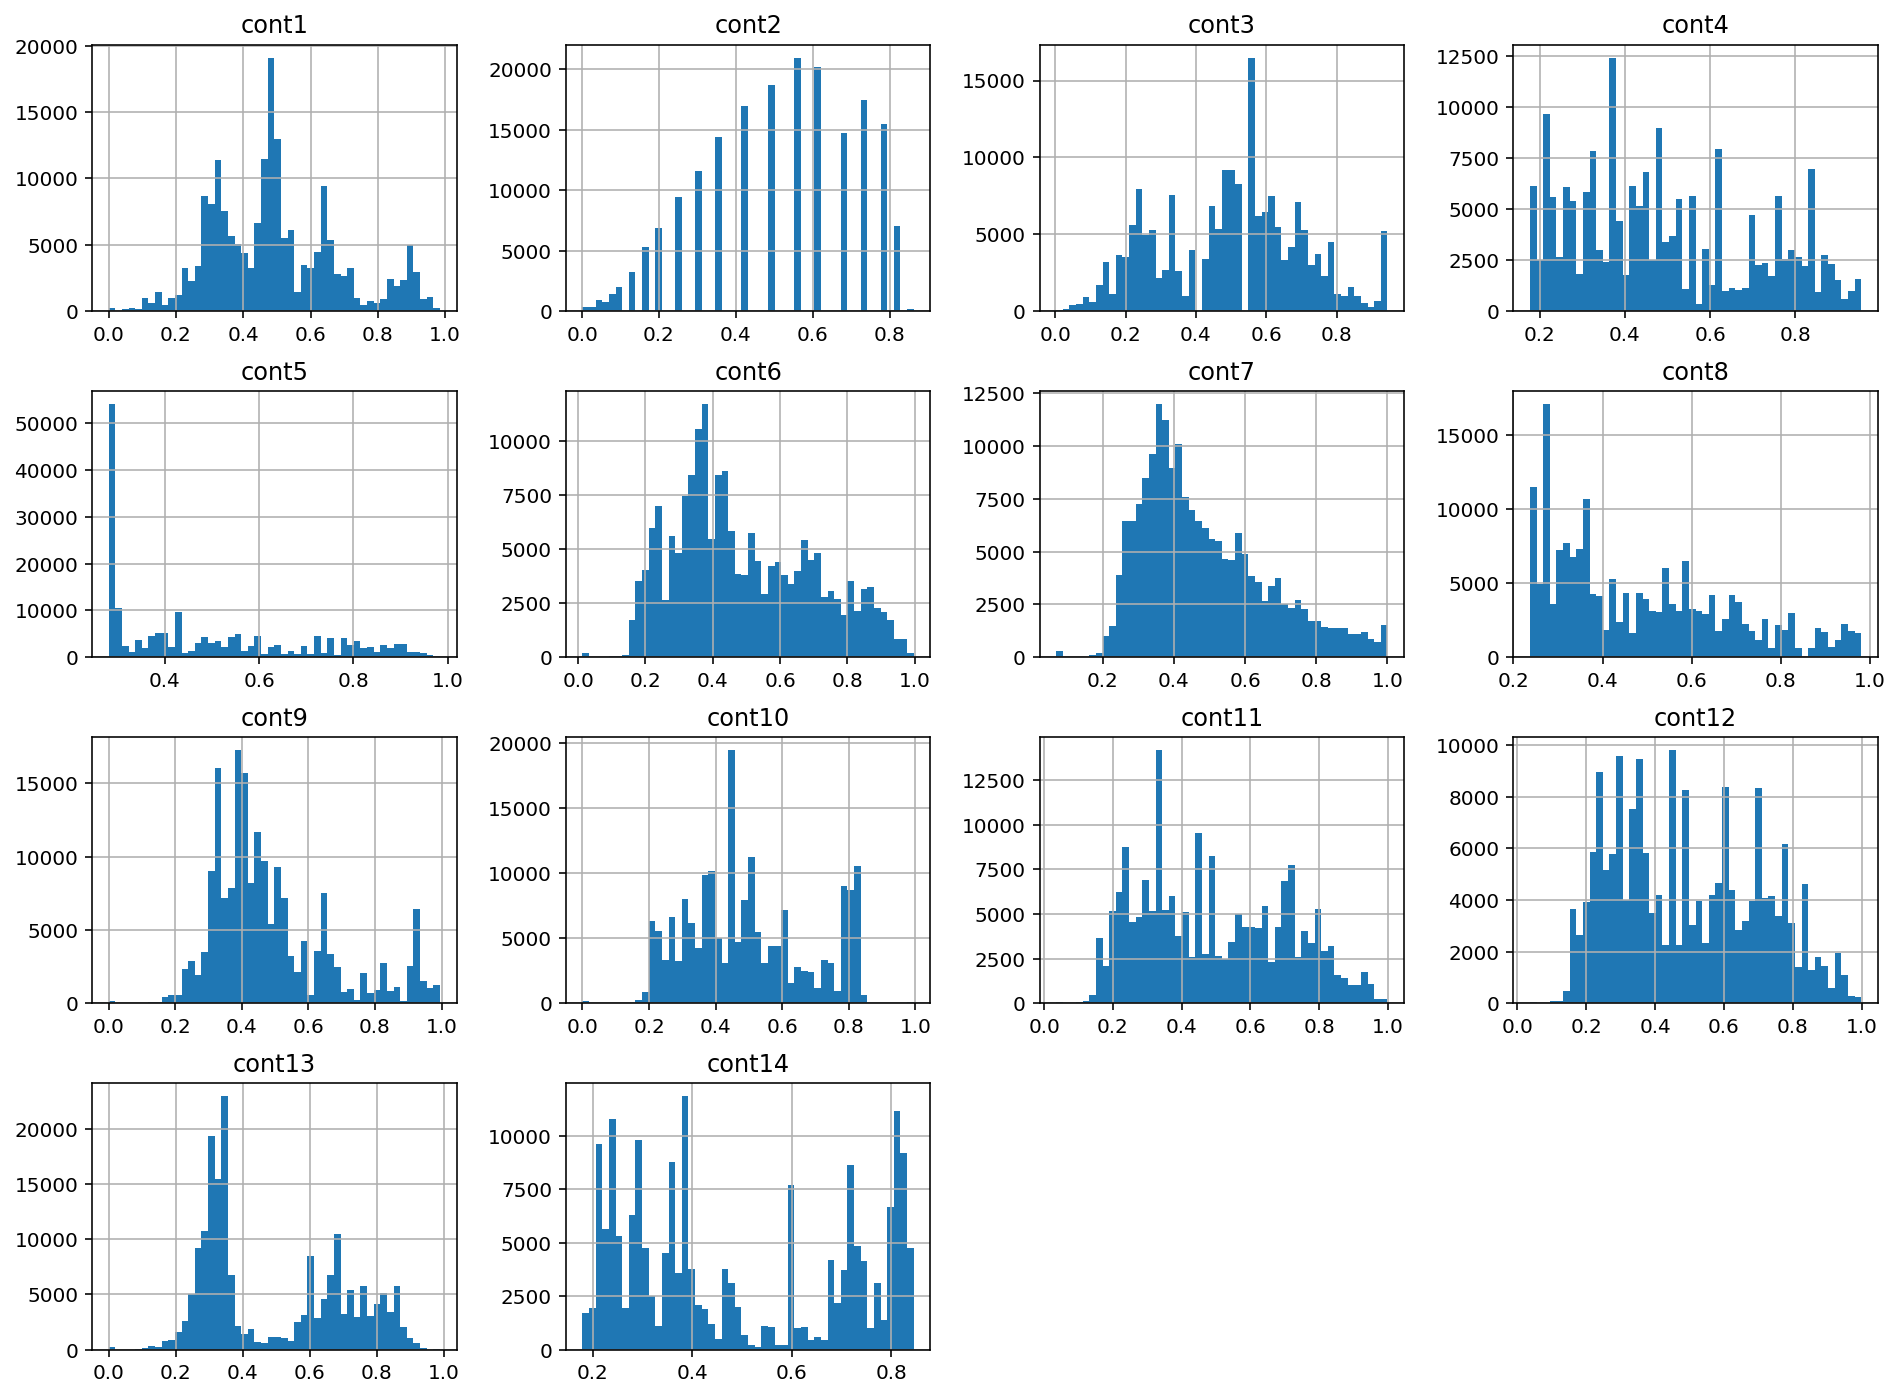

In [62]:
train[cont_features].hist(bins=50, figsize=(16,12))

We see plots with many spikes which don't follow any reasonable PDF. Such plots point out that the data might have been converted from categorical to continuous to be represented as a real number.

I'd still transformed these features making their distribution more gaussian, but I don't consider it can dramatically improve the model's performance.

### Feature Correlation (Pearson)

We can definitely visualize correlations among all numerical features. We use an out-of-the-box solution (`pd.corr`) which relies on Pearson coefficient.

<AxesSubplot:>

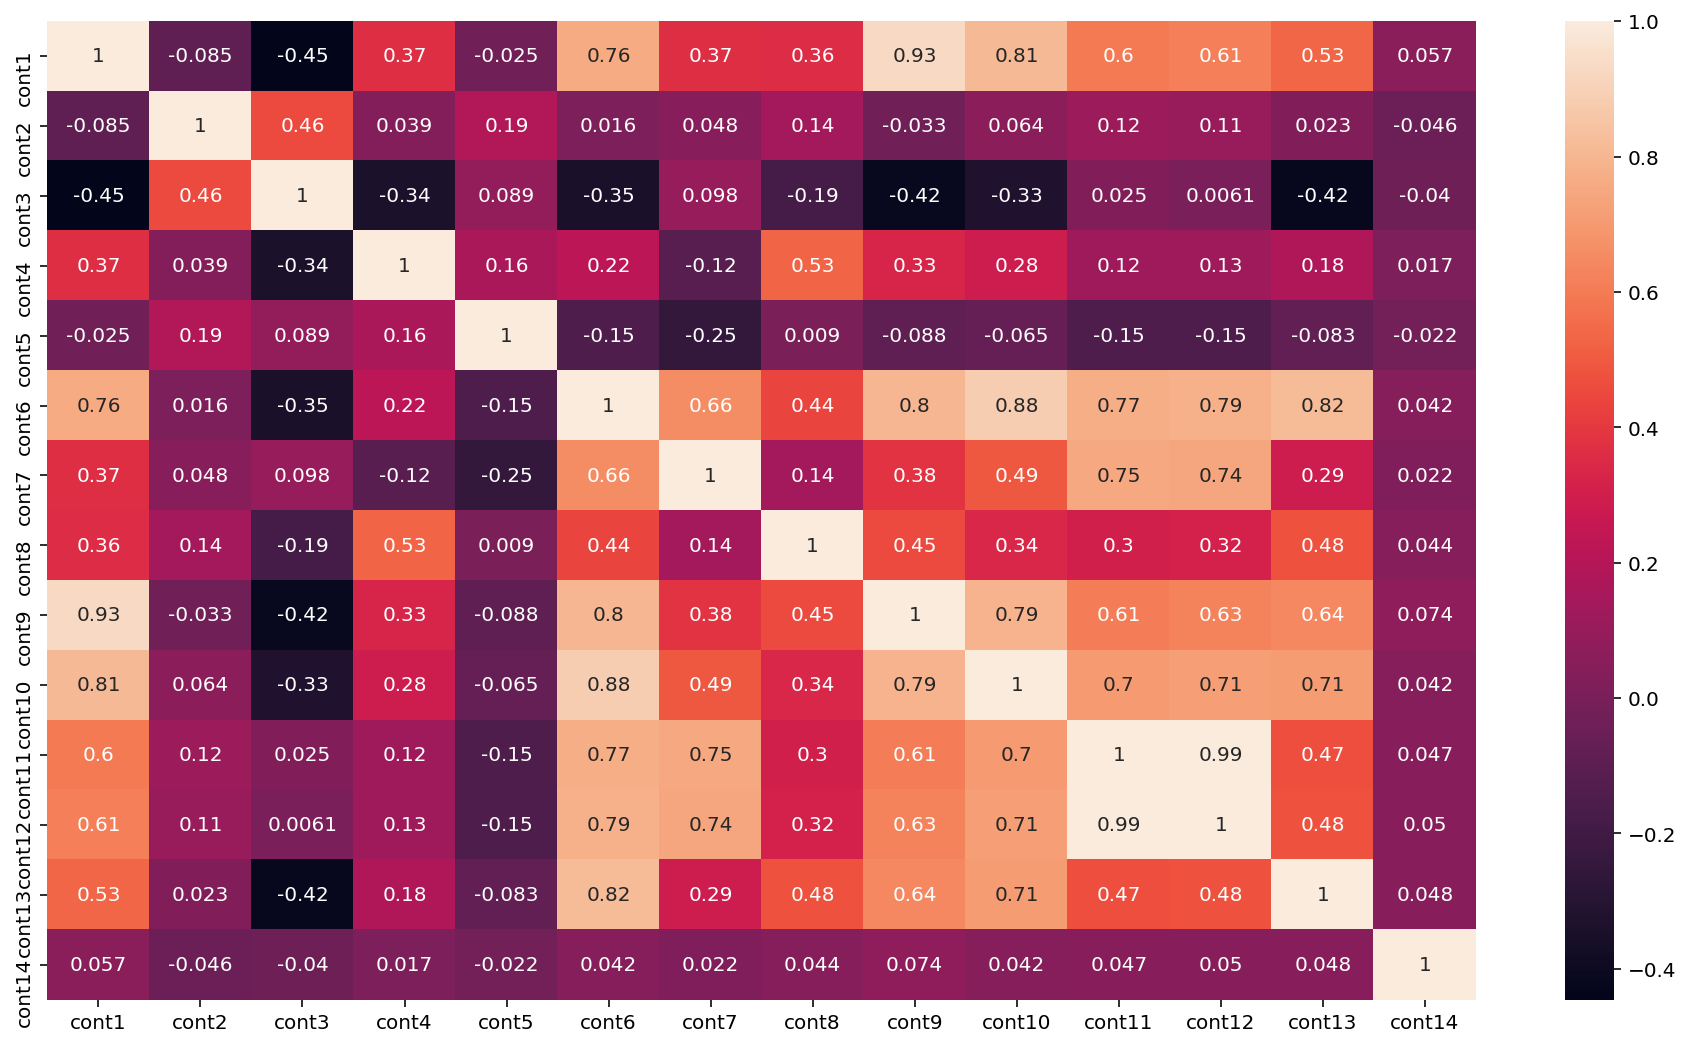

In [63]:
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat, annot=True)

We see a high correlation among several features. This may be a result of a [data-based multicollinearity](https://onlinecourses.science.psu.edu/stat501/node/344) as two or more predictors are highly correlated. There are many [problems](https://onlinecourses.science.psu.edu/stat501/node/346) it causes, so we should be very careful while implementing linear regression models on current dataset.

## Comparing train and test set distributions

In order to get reliable predictions on test set, we need to make sure that the test data is distributed the same way as the training data does. If we do confirm that the data is equally distributed, this allows us to cross-validate on training set as well as 

One way is to arrange a statistical test. A good option is [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test): it is used to test the hypothesis that two distributions have equal means and works well when two samples have unequal variances and sample sizes.

A downside of this approach is that we have to test features one by one.

On the other hand, we may use ML algorithms to see whether there's a significant different between train and test. We use the method described as [Adversarial validation](http://fastml.com/adversarial-validation-part-one/).

The idea is to mix training and test sets and to see if a classifier (a logistic regression or a decision tree) can separate one from the other.

In [64]:
# Simple data preparation

train_d = train.drop(['id','loss'], axis=1)
test_d = test.drop(['id'], axis=1)

# To make sure we can distinguish between two classes
train_d['Target'] = 1
test_d['Target'] = 0

# We concatenate train and test in one big dataset
data = pd.concat((train_d, test_d))

# We use label encoding for categorical features:
data_le = deepcopy(data)
for c in range(len(cat_features)):
    data_le[cat_features[c]] = data_le[cat_features[c]].astype('category').cat.codes

# We use one-hot encoding for categorical features:
data = pd.get_dummies(data=data, columns=cat_features)

MemoryError: Unable to allocate 138. MiB for an array with shape (115, 313864) and data type object

Recreating training and test sets:

In [65]:
data = data.iloc[np.random.permutation(len(data))]
data.reset_index(drop = True, inplace = True)

x = data.drop(['Target'], axis = 1)
y = data.Target

train_examples = 100000

x_train = x[:train_examples]
x_test = x[train_examples:]
y_train = y[:train_examples]
y_test = y[train_examples:]

MemoryError: Unable to allocate 139. MiB for an array with shape (116, 313864) and data type object

Now we train two classifiers: 1) logistic regression and 2) random forest — and use them to predict our test:

In [23]:
# Logistic Regression:
clf = LogisticRegression()
clf.fit(x_train, y_train)
pred = clf.predict_proba(x_test)[:,1]
auc = AUC(y_test, pred)
print "Logistic Regression AUC: {:.2%}".format(auc)

# Random Forest, a simple model (100 trees) trained in parallel
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(x_train, y_train)
pred = clf.predict_proba(x_test)[:,1]
auc = AUC(y_test, pred)
print "Random Forest AUC: {:.2%}".format(auc)

# Finally, CV our results (a very simple 2-fold CV):
scores = cross_val_score(LogisticRegression(), x, y, scoring='roc_auc', cv=2)
print "Mean AUC: {:.2%}, std: {:.2%} \n".format( scores.mean(), scores.std())

Logistic Regression AUC: 50.05%
Random Forest AUC: 49.81%
Mean AUC: 49.90%, std: 0.01% 



As we see from the results above, ROC AUC score is close to 0.5 (50%). We may conclude that neither a LR, nor a RF could find a difference between training and test set. This leads us to the thought that the training and test sets are drawn from the same distribution. A simple way to do so is just to use `train_test_split` in cross-validation module.

We can also visualize our dataset using PCA. We project multidimensional dataset (130D, as we remember) to 2D:

In [24]:
# Shuffle train and test
data_le = data_le.iloc[np.random.permutation(len(data_le))]

In [25]:
# And run PCA transformation
X = data_le.iloc[:, :130]
y = data_le.iloc[:, 130:]

pca = PCA(n_components=2)

X_reduced = pca.fit_transform(X)

As we see, green and blue labels (train and test examples respectively) are scattered across the space in similar manner and we can't spot any patterns which could help us distinguish one from the other.

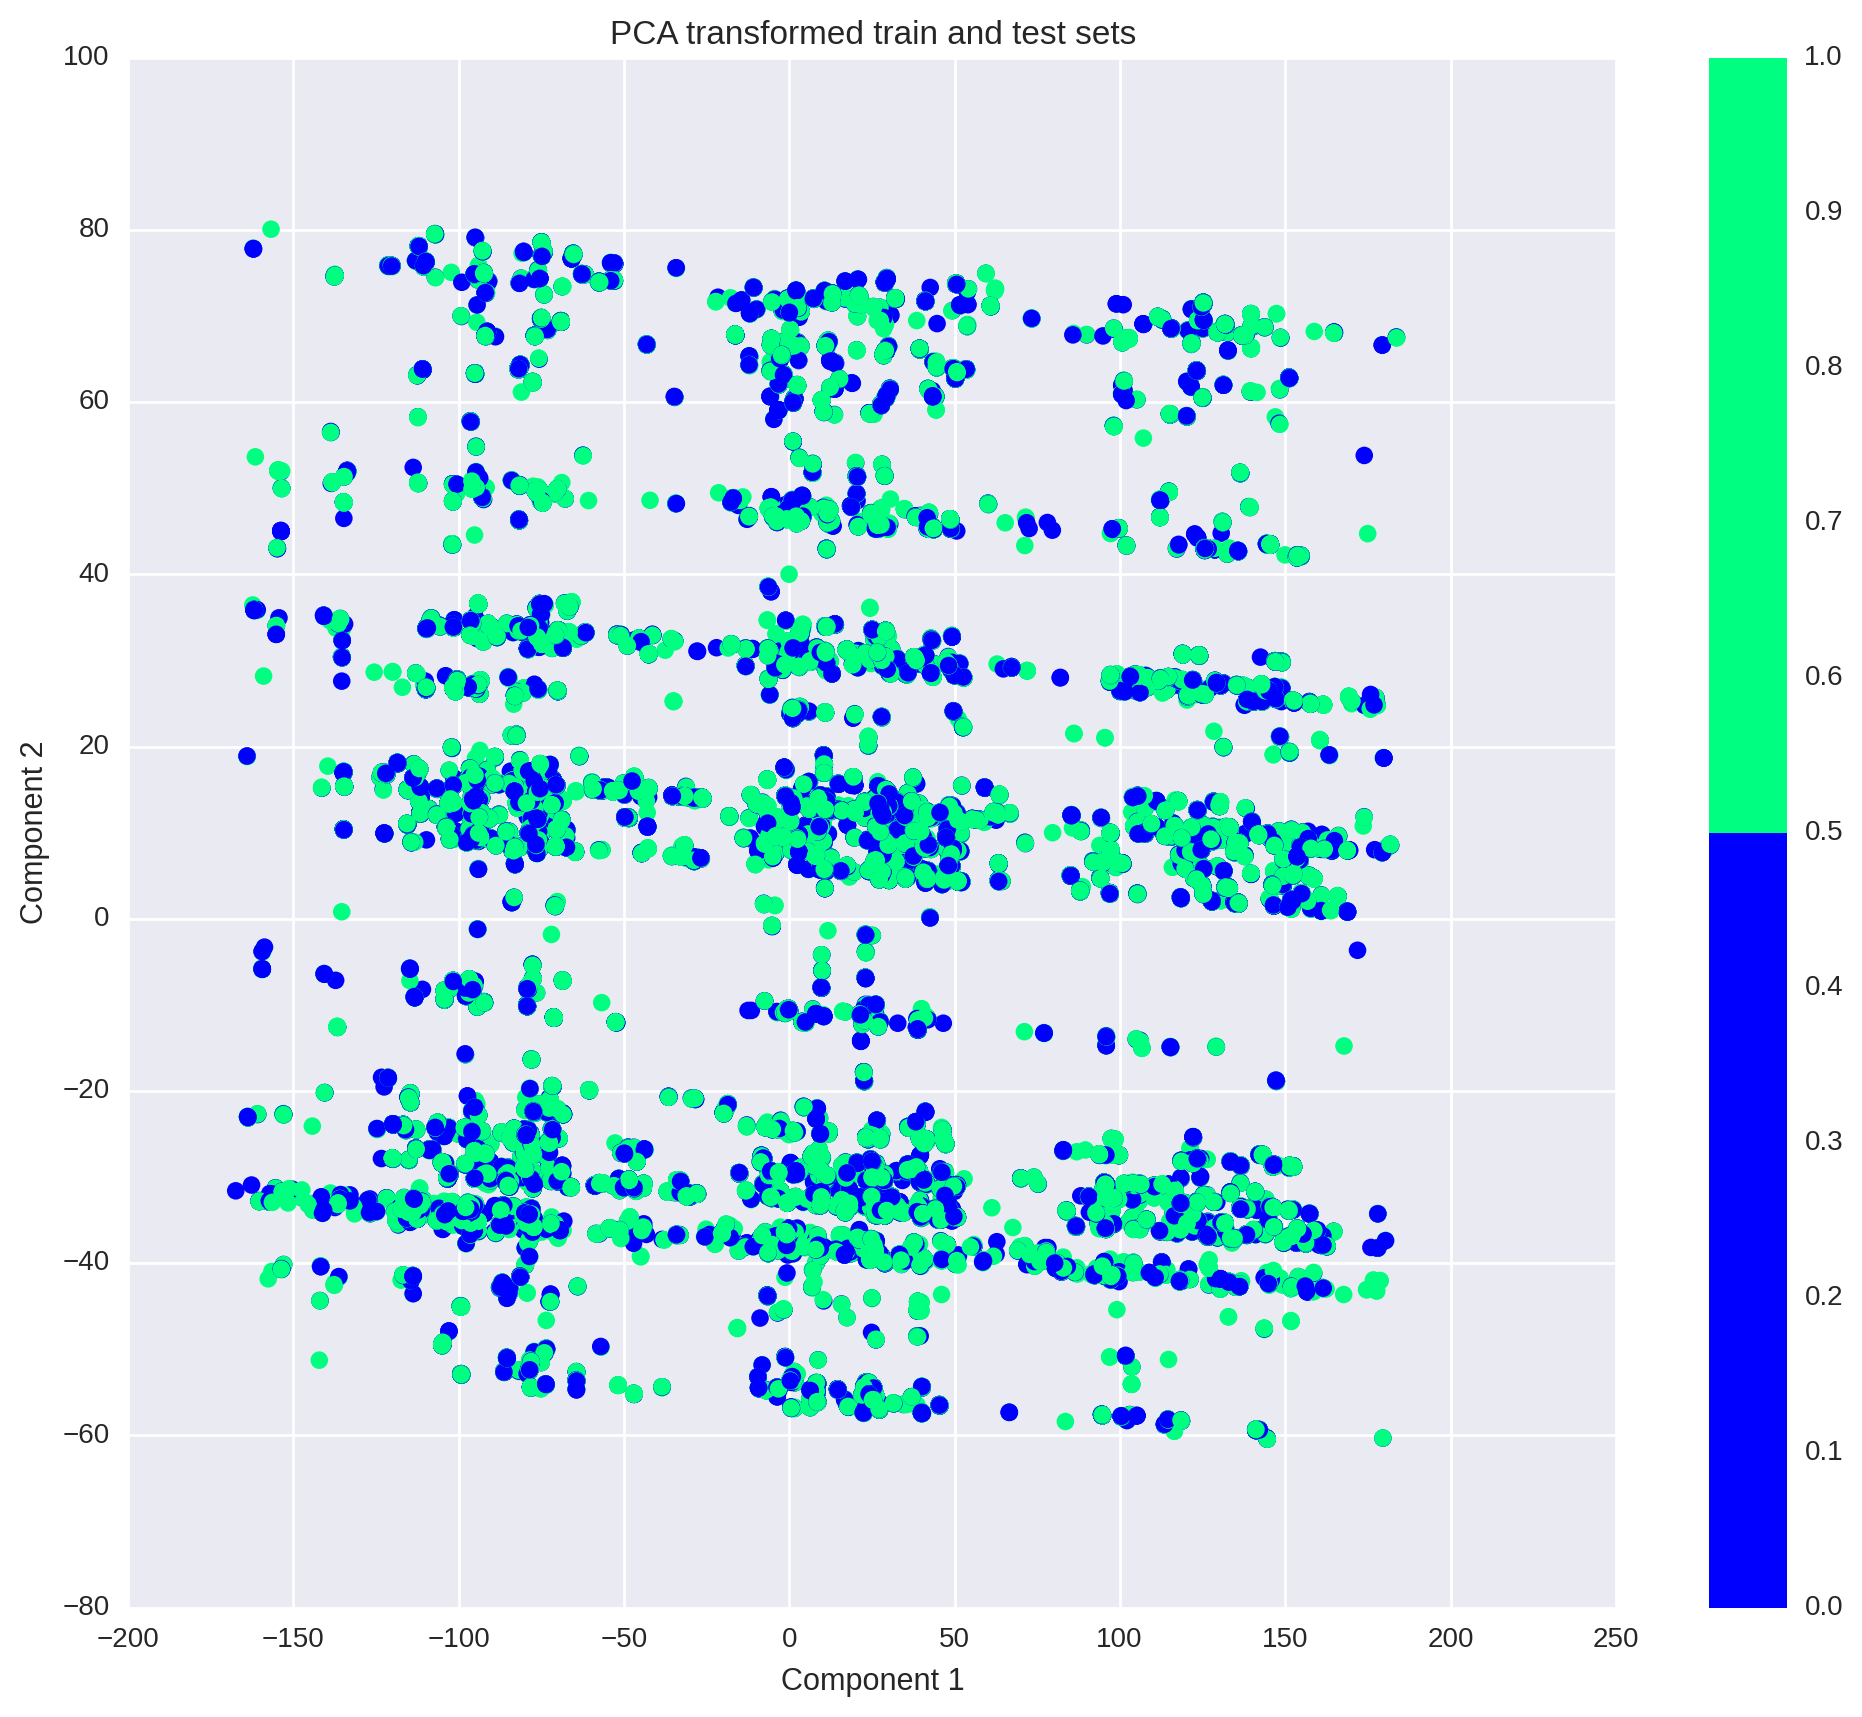

In [26]:
# Train = 1, Test = 0
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=np.array(y), 
            edgecolor='none', s=40,
            cmap=plt.cm.get_cmap('winter', 2))
plt.title('PCA transformed train and test sets')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()